In [7]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from IPython.display import Video
%matplotlib inline

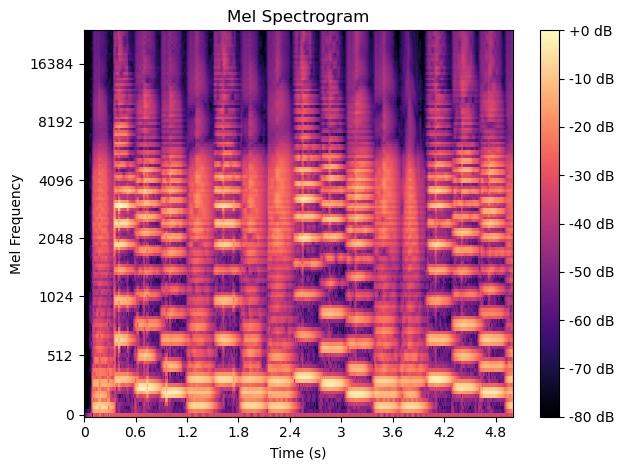

In [8]:
y,sr = librosa.load("Larytta - Wonder Vendor (Live @ KEXP).mp3", sr = None, duration = 5)

tempo, beats= librosa.beat.beat_track(y=y, sr=sr)
loudness = librosa.feature.rms(y=y)[0]
brightness = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

def normalize(x):
  return (x - np.min(x)) / (np.max(x) - np.min(x))

loudness_norm = np.array(normalize(loudness))
brightness_norm = np.array(normalize(brightness))

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

S_db = librosa.power_to_db(S, ref=np.max)
S_db_norm = normalize(S_db)

fig, axs = plt.subplots()

img = librosa.display.specshow(S_db, x_axis='time', y_axis='mel',
                               sr=sr, ax= axs)

axs.set_title("Mel Spectrogram")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Mel Frequency")

fig.colorbar(img, ax=axs, format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [9]:
mel_freqs = librosa.mel_frequencies(n_mels=128, fmax=16000)
norm_freq = (mel_freqs - mel_freqs.min()) / (mel_freqs.max() - mel_freqs.min())

def rgb_linear(f):
    r = f
    g = 1 - f
    b = 0.5*f + 0.5
    return np.stack([r, g, b], axis=1)

def rgb_sin(f, k=3):
    r = 0.5 + 0.5 * np.sin(2 * np.pi * k * f)
    g = 0.5 + 0.5 * np.sin(2 * np.pi * k * f + 2*np.pi/3) #+2pi/3 phase shift
    b = 0.5 + 0.5 * np.sin(2 * np.pi * k * f + 4*np.pi/3) #+4pi/3 phase shift
    return np.stack([r, g, b], axis=1)

def rgb_mix(f, k=3):
    r = 0.5 + 0.5 * np.sin(2 * np.pi * k * f)
    g = (np.tanh(4 * (f - 0.5)) + 1) / 2
    b_raw = np.exp(-3 * f)
    b = (b_raw - b_raw.min()) / (b_raw.max() - b_raw.min())
    return np.stack([r, g, b], axis=1)

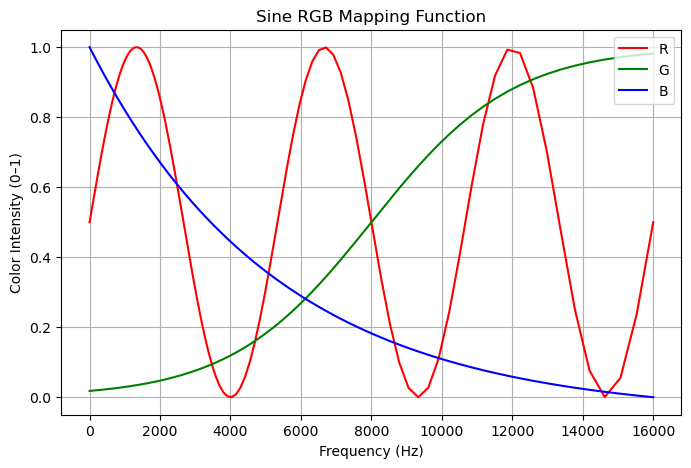

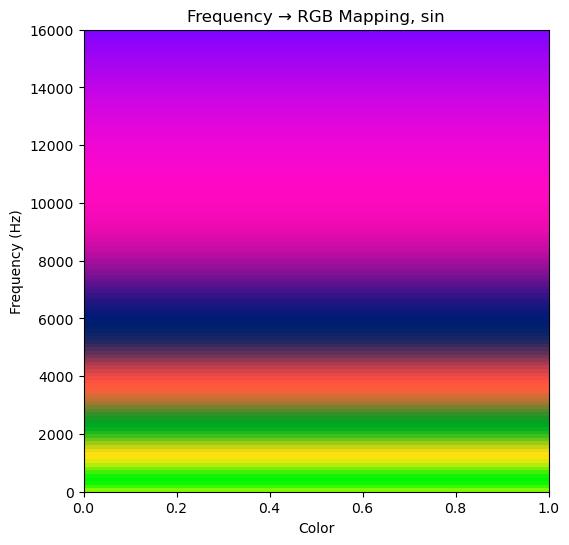

In [10]:
rgb_values = rgb_mix(norm_freq) 

fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(mel_freqs, rgb_values[:, 0], 'r', label='R')
ax1.plot(mel_freqs, rgb_values[:, 1], 'g', label='G')
ax1.plot(mel_freqs, rgb_values[:, 2], 'b', label='B')

ax1.set_title("Sine RGB Mapping Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Color Intensity (0–1)")
ax1.legend(loc="upper right")
ax1.grid()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(rgb_values.reshape(-1, 1, 3), aspect='auto', extent=[0, 1, mel_freqs[0], mel_freqs[-1]])
ax.set_title("Frequency → RGB Mapping, sin")
ax.set_xlabel("Color")
ax.set_ylabel("Frequency (Hz)")
ax.set_yscale("linear")
plt.show()

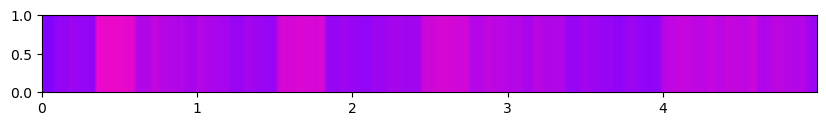

In [11]:
y,sr = librosa.load("Larytta - Wonder Vendor (Live @ KEXP).mp3", sr = None, duration = 5)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

weights = S / np.sum(S, axis=0, keepdims=True)
rgb_values = rgb_mix(norm_freq)
time_colors = np.dot(weights.T, rgb_values)

times = librosa.frames_to_time(np.arange(S.shape[1]), sr=sr)

plt.figure(figsize=(10, 1))
plt.imshow(time_colors.reshape(1, -1, 3), aspect='auto', extent=[times[0], times[-1], 0, 1])
plt.show()

In [17]:
audio_file = "Larytta - Wonder Vendor (Live @ KEXP).mp3"
freq_strength = S_db_norm.mean(axis=0)  

M, N = 256, 256
num_frames = 500
fps = 30

freq_t = np.linspace(0, len(freq_strength) - 1, num_frames)
freq_sampled = np.interp(freq_t, np.arange(len(freq_strength)), freq_strength) 
#freq_strength and num_frames don't match,so stretches or compresses freq_strength produces exactly one value per video frame

rgb_values = rgb_mix(freq_sampled)   # shape (num_frames, 3)


canvas_flat = np.zeros((M * N, 3), dtype=np.float32)

temp_video = "random_strokes_temp.mp4"
final_video = "random_strokes_with_audio.mp4"

cmd = [
    "/opt/homebrew/bin/ffmpeg",
    "-y",
    "-f", "rawvideo",
    "-vcodec", "rawvideo",
    "-pix_fmt", "rgb24",
    "-s", f"{N}x{M}",
    "-r", str(fps),
    "-i", "-",
    "-an",
    "-vcodec", "libx264",
    "-pix_fmt", "yuv420p",
    temp_video
]

process = subprocess.Popen(cmd, stdin=subprocess.PIPE)

for t in range(num_frames):
    color = rgb_values[t]

    x0, y0 = np.random.uniform(0, N), np.random.uniform(0, M)
    dx, dy = np.random.uniform(-6, 6), np.random.uniform(-6, 6)

    stroke_width = np.random.randint(1, 6)
    half_w = stroke_width // 2

    for s in range(20):
        xi = x0 + dx * s / 20
        yi = y0 + dy * s / 20

        i = int(xi)
        j = int(yi)

        if 0 <= i < N and 0 <= j < M:
            ij = j * N + i

            for di in range(-half_w, half_w + 1):
                for dj in range(-half_w, half_w + 1):
                    ni = i + di
                    nj = j + dj

                    if 0 <= ni < N and 0 <= nj < M:
                        nij = nj * N + ni
                        canvas_flat[nij] = color

    frame = canvas_flat.reshape(M, N, 3)
    process.stdin.write((frame * 255).astype(np.uint8).tobytes())

process.stdin.close()
process.wait()

print("Visual-only video saved.")

cmd_audio = [
    "/opt/homebrew/bin/ffmpeg",
    "-y",
    "-i", temp_video,
    "-i", audio_file,
    "-shortest",
    "-c:v", "copy",
    final_video
]

subprocess.run(cmd_audio)

print(f"Final video saved as {final_video}")
Video(final_video, embed=True)

ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --e

Visual-only video saved.
Final video saved as random_strokes_with_audio.mp4


[out#0/mp4 @ 0x600001fb4000] video:68KiB audio:268KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 5.733617%
frame=  500 fps=0.0 q=-1.0 Lsize=     356KiB time=00:00:16.60 bitrate= 175.6kbits/s speed=33.9x elapsed=0:00:00.48    
[aac @ 0x136006a60] Qavg: 340.062


In [18]:
freq_strength = S_db_norm.mean(axis=0)

num_frames = 500
fps = 30

freq_t = np.linspace(0, len(freq_strength) - 1, num_frames)
freq_sampled = np.interp(freq_t, np.arange(len(freq_strength)), freq_strength)

rgb_values = rgb_mix(freq_sampled)
rgb_values = np.clip(rgb_values, 0, 1)

M, N = 256, 256
visual_only = "random_walk_temp.mp4"
final_output = "random_walk_with_audio.mp4"

cmd = [
    "ffmpeg", "-y",
    "-f", "rawvideo", "-vcodec", "rawvideo",
    "-s", f"{N}x{M}",
    "-pix_fmt", "rgb24",
    "-r", str(fps),
    "-i", "-",
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "-preset", "fast",
    visual_only
]
process = subprocess.Popen(cmd, stdin=subprocess.PIPE)


canvas = np.zeros((M * N, 3), dtype=np.uint8)

x, y = M // 2, N // 2
dx, dy = 0.0, 0.0
step_size = 10

for t in range(num_frames):

    color = (rgb_values[t] * 255).astype(np.uint8)

    brush_w = np.random.randint(1, 6)
    half = brush_w // 2

    new_x = x + dx * step_size
    new_y = y + dy * step_size

    # Reflect at boundaries
    if new_x < 0 or new_x >= M:
        dx *= -1
        new_x = np.clip(new_x, 0, M - 1)
    if new_y < 0 or new_y >= N:
        dy *= -1
        new_y = np.clip(new_y, 0, N - 1)

    dx += np.random.uniform(-1, 1)
    dy += np.random.uniform(-1, 1)
    norm = np.hypot(dx, dy)
    dx, dy = dx / norm, dy / norm

    num_steps = int(np.hypot(new_x - x, new_y - y)) + 1
    xs = np.linspace(int(x), int(new_x), num_steps).astype(int)
    ys = np.linspace(int(y), int(new_y), num_steps).astype(int)

    for px, py in zip(xs, ys):
        for wx in range(-half, half + 1):
            for wy in range(-half, half + 1):
                i = px + wx
                j = py + wy
                if 0 <= i < N and 0 <= j < M:
                    ij = j * N + i
                    canvas[ij] = color
    x, y = new_x, new_y

    frame = canvas.reshape(M, N, 3)
    process.stdin.write(frame.tobytes())

process.stdin.close()
process.wait()
print("Visual-only video saved.")

audio_file = "Larytta - Wonder Vendor (Live @ KEXP).mp3"
cmd_audio = [
    "ffmpeg", "-y",
    "-i", visual_only,
    "-i", audio_file,
    "-shortest",
    "-c:v", "copy",
    final_output
]
subprocess.run(cmd_audio)

print(f"Final video with audio saved as {final_output}")
Video(final_output, embed=True)

ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --e

Visual-only video saved.
Final video with audio saved as random_walk_with_audio.mp4


[out#0/mp4 @ 0x6000032a8000] video:62KiB audio:268KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 5.685282%
frame=  500 fps=0.0 q=-1.0 Lsize=     349KiB time=00:00:16.60 bitrate= 172.1kbits/s speed=  35x elapsed=0:00:00.47    
[aac @ 0x139705650] Qavg: 419.284
